In [ ]:
import re
import pandas as pd
from Bio import SeqIO
from collections import defaultdict
from tqdm.notebook import tqdm

# Code block of main extracting function

def reverse_complement(seq):
    complement = str.maketrans("acgtACGT", "tgcaTGCA")
    return seq.translate(complement)[::-1]

def load_reference_genome(fasta_path):
    ref_dict = {}
    for record in SeqIO.parse(fasta_path, "fasta"):
        ref_dict[record.id] = str(record.seq).lower()
    return ref_dict

def parse_cigar(cigar):
    ops = re.findall(r'(\d+)([MID])', cigar)
    counts = {'M': 0, 'I': 0, 'D': 0}
    for length, op in ops:
        counts[op] += int(length)
    return counts['M'], counts['I'], counts['D']

def parse_cs(cs, ref_seq_segment=None):
    subs = re.findall(r'\*([acgt])([acgt])', cs)
    ins = re.findall(r'\+([acgt]+)', cs)
    dels = re.findall(r'-([acgt]+)', cs)
    matches = re.findall(r':(\d+)', cs)
    
    replacements = defaultdict(int)
    replacements['a->a'] = ref_seq_segment.count('a')+ref_seq_segment.count('A')
    replacements['c->c'] = ref_seq_segment.count('c')+ref_seq_segment.count('C')
    replacements['g->g'] = ref_seq_segment.count('g')+ref_seq_segment.count('G')
    replacements['t->t'] = ref_seq_segment.count('t')+ref_seq_segment.count('T')
    
    for old, new in subs:
        replacement_key = f"{old}->{new}"
        replacements[replacement_key] += 1
        replacements[f'{old}->{old}'] -= 1

    return {
        "cs_matches": sum(map(int, matches)),
        "cs_substitutions": len(subs),
        "cs_insertions": sum(len(i) for i in ins),
        "cs_deletions": sum(len(d) for d in dels),
        **replacements
    }
    
def extract_stats_from_paf_table(paf_path, ref_fasta_path):
    ref_dict = load_reference_genome(ref_fasta_path)
    print('Loading reference genome completed')

    stats_list = []

    with open(paf_path, 'r') as f:
        lines = f.readlines()

    for line in tqdm(lines, desc="Processing PAF", unit="read", total=len(lines)):
        fields = line.strip().split('\t')
        if len(fields) < 12:
            continue

        query_name = fields[0]
        ref_name = fields[5]
        ref_start = int(fields[7])
        ref_end = int(fields[8])
        ref_span = ref_end - ref_start

        optional_fields = fields[12:]
        cigar_field = next((f for f in optional_fields if f.startswith("cg:Z:")), None)
        cs_field = next((f for f in optional_fields if f.startswith("cs:Z:")), None)

        if not cigar_field or not cs_field:
            continue

        cs_string = cs_field[5:]
        cigar_string = cigar_field[5:]
        cigar_M, cigar_I, cigar_D = parse_cigar(cigar_string)

        ref_seq_segment = ref_dict.get(ref_name, '')[ref_start:ref_end]

        cs_stats = parse_cs(cs_string, ref_seq_segment=ref_seq_segment)

        cigar_error_bases = cs_stats['cs_substitutions'] + cs_stats['cs_insertions'] + cs_stats['cs_deletions']
        cigar_alignment_span = cs_stats['cs_matches'] + cs_stats['cs_insertions'] + cs_stats['cs_deletions']
        error_rate = cigar_error_bases / cigar_alignment_span if cigar_alignment_span > 0 else None

        row_stats = {
            "query_name": query_name,
            "ref_name": ref_name,
            "ref_span": ref_span,
            "cigar_matches": cigar_M,
            "cigar_insertions": cigar_I,
            "cigar_deletions": cigar_D,
            "cigar_error_bases": cigar_error_bases,
            "cigar_alignment_span": cigar_alignment_span,
            "error_rate": error_rate,
            **cs_stats
        }

        stats_list.append(row_stats)

    return pd.DataFrame(stats_list)

In [2]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns

# Code block of plotting

def plot_heatmap(confusion_matrix, motifs, output_file, need_save = False):
    # orange = ["#f8f8f8", "#ED6C00"]
    azure = ["#f8f8f8", "#2BB7B3"]
    # darkgreen = ["#f8f8f8", "#003F43"]
    df_cm = pd.DataFrame(confusion_matrix.T, index=motifs, columns=motifs)

    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", azure, N=100)

    plt.figure(figsize=(5, 5))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', cmap=custom_cmap, annot_kws={"size": 12}, cbar_kws={'label': 'Substitution (%)'})

    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(12)
    cbar.ax.tick_params(labelsize=12)

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Query Base', fontsize=12)
    plt.ylabel('Reference Base', fontsize=12)
    plt.tight_layout()
    plt.savefig(output_file) if need_save else None
    plt.show()

In [ ]:
df = extract_stats_from_paf_table(
    paf_path="./minimap2_rsts/Salmonella_enterica_output.paf",
    ref_fasta_path="./refs/Salmonella_enterica/GCF_000006945.2_ASM694v2_genomic.fna",
)

Loading reference genome completed


Processing PAF:   0%|          | 0/85033 [00:00<?, ?read/s]

In [4]:
from itertools import product
import numpy as np

bases = ['a', 'c', 'g', 't']
base_change_matrix = np.zeros((4, 4), dtype=int)
for base in product(bases, repeat=2):
    base_change = f"{base[0]}->{base[1]}"
    if base_change in df.columns:
        base_change_matrix[bases.index(base[0]), bases.index(base[1])] = df[base_change].sum()
        
row_sum = np.sum(base_change_matrix, axis=1, keepdims=True)
base_change_percentage = np.divide(base_change_matrix * 100, row_sum, where=row_sum != 0)
base_change_percentage

array([[94.01032896,  1.28710884,  3.57031025,  1.13225195],
       [ 1.42187332, 93.13628834,  1.73024142,  3.71159692],
       [ 3.76623263,  1.71609065, 93.10028231,  1.41739441],
       [ 1.12917838,  3.5631737 ,  1.31183612, 93.9958118 ]])

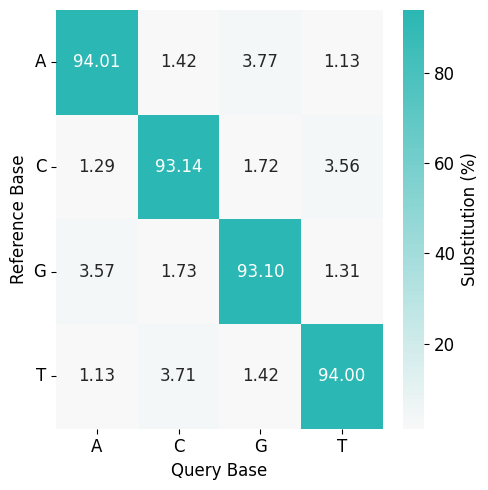

In [5]:
motifs = [''.join(_) for _ in product('ACGT', repeat=1)]
plot_heatmap(base_change_percentage, motifs, './', need_save=False)